<a href="https://colab.research.google.com/github/trbella/2022-05-environment_international/blob/main/notebooks/best_models/LR-SARIMAX/LR-SARIMAX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**READ ME**: 
**Author: Thiago Ribas Bella**

In this notebook I fitted the best linear regression models with SARIMAX errors (LR-SARIMAX) for daily, weekly and monthly data.

##**REQUIREMENTS**

In [ ]:
#uploading the requirements.txt file
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving requirements.txt to requirements.txt
User uploaded file "requirements.txt" with length 750 bytes


##**INSTALLING REQUIREMENTS**

In [ ]:
!pip install -r requirements.txt

##**LIBRARIES**

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from scipy.stats import mannwhitneyu as mwu
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


##**FUNCTIONS**

In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
  # dataset varaibles quantity
  n_vars = 1 if type(data) is list else data.shape[1]
  # dataframe transformation
  df = pd.DataFrame(data)
  cols, names = list(), list()

  # input sequence (t-n, ... t-1). lags before time t
  for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
    names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]

  # forecast sequence (t, t+1, ... t+n). lags after time t
  for i in range(0, n_out):
    cols.append(df.shift(-i))
    if i == 0:
      names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
    else:
      names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
  # put it all together
  agg = pd.concat(cols, axis=1)
  agg.columns = names
  # drop rows with NaN values
  if dropnan:
    agg.dropna(inplace=True)
  return agg

def mape_vectorized(true, pred): 
    mask = true != 0
    return (np.fabs(true - pred)/true)[mask].mean()*100

##**LOAD DATA**

In [ ]:
df = pd.read_csv('/content/drive/Shared drives/Clima&Saúde/Dados/Dados_Saude/Obitos_SSC/data/processed/2001-2018_obitos_clima_diario.csv')
df['DATE'] = pd.to_datetime(df['DATE'],dayfirst=True)
df = df.set_index('DATE')
df.head(5)

,CO_MIN,CO_MAX,CO_MEAN,PM10_MIN,PM10_MAX,PM10_MEAN,TMIN_IAC,TMAX_IAC,TMIN_VC,TMAX_VC,...,mi_black_F,avc_white,avc_brown,avc_black,avc_white_M,avc_brown_M,avc_black_M,avc_white_F,avc_brown_F,avc_black_F
DATE,,,,,,,,,,,,,,,,,,,,,
2001-01-01,0.6,1.2,0.804348,NaN,NaN,NaN,18.2,28.2,17.8,27.9,...,0,2,0,0,0,0,0,2,0,0
2001-01-02,0.4,1.9,1.078261,NaN,NaN,NaN,17.8,30.0,16.6,29.8,...,0,1,0,0,0,0,0,1,0,0
2001-01-03,0.4,2.5,1.239130,NaN,NaN,NaN,18.0,30.4,17.3,29.6,...,0,2,0,0,2,0,0,0,0,0
2001-01-04,0.5,2.0,1.166667,23.0,65.0,44.7,18.4,30.4,17.8,30.0,...,0,2,0,0,1,0,0,1,0,0
2001-01-05,0.4,2.5,1.334783,4.0,59.0,26.5,17.8,31.4,17.5,31.1,...,0,2,0,0,2,0,0,0,0,0


##**Spliting Endogenous and Exogenous Variables**

I decided to maintain only some exogenous variables to fit the model:

- **CARBON MONOXIDE**: We chose to work with mean levels of CO (**CO_MEAN**).
- **PARTICULATE MATTER 10 um**: We chose to work with mean levels of PM10 (**PM10_MEAN**).
- **TEMPERATURE**: We chose **TMIN** only for **IAC** (**TMIN_IAC**) due its good precision.

The best LR-SARIMAX models in each frequency were:

- Daily: 
    - model parameters:  (5,1,1)(0,0,2,7) + intercept
    - variables:T_MIN and CO_MEAN
    - lags: 13

- weekly:
    - model parameters: (1,1,2)(0,0,0,4) + intercept
    - variables: T_MIN
    - lags: 3

- Monthly:
    - model parameters: (1,1,1)(1,0,1,12)
    - variables: T_MIN, CO_MEAN and PM10_MEAN
    - lags: 1


In [ ]:
#rename minimum temperature variable
df = df.rename(columns={'TMIN_IAC':'T_MIN'})

#**DAILY DATA**

In [ ]:
# Variables
endog = df.loc[:]['all']
exog = df.loc[:][['CO_MEAN','PM10_MEAN','T_MIN']]

##**Pearson's correlation graph - exogenous variables**

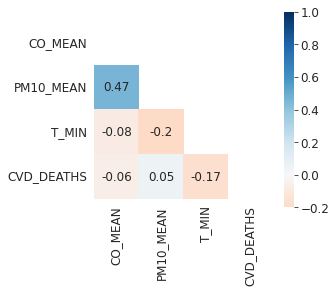

In [ ]:
pear = round(exog.corr(method='pearson'),2)
mask = np.zeros_like(pear)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(4, 4))
    ax = sns.heatmap(pear, mask=mask, vmax=1, square=True,center=0,annot=True,annot_kws={"fontsize":12}, cmap="RdBu",cbar_kws={"shrink": .9})
    plt.xticks(fontsize=12,rotation=90)
    plt.yticks(fontsize=12,rotation=0)
    cax = plt.gcf().axes[-1] 
    cax.tick_params(labelsize=12) 

## **Fill Exogenous missing values with general mean of each variable**

In [ ]:
#set data frequency
endog = endog.asfreq('D')
exog = exog.asfreq('D')

#Check Missing values
print('Missing values')
print('CVD_DEATHS    ',np.sum(endog.isnull()))
print(np.sum(exog.isnull()),'\n')

#fill exogenous nan with mean (for each exogenous variable)
exog = exog.fillna(exog.mean())

#Check NaN
print('Missing values')
print('CVD_DEATHS  ',np.sum(endog.isnull()))
print(np.sum(exog.isnull()))

Missing values
CVD_DEATHS     0
CO_MEAN      328
PM10_MEAN    242
T_MIN          0
dtype: int64 

Missing values
CVD_DEATHS   0
CO_MEAN      0
PM10_MEAN    0
T_MIN        0
dtype: int64


##**Descriptive statistics - daily data**

In [ ]:
# Variables
graphs_data = exog
graphs_data['CVD_DEATHS'] = endog
colu = ['CVD_DEATHS','T_MIN','CO_MEAN','PM10_MEAN']
graphs_data = graphs_data[colu]

In [ ]:
graphs_data.describe()[1:]

,CVD_DEATHS,T_MIN,CO_MEAN,PM10_MEAN
mean,6.289322,16.638318,1.057810,33.256795
std,2.653122,3.287252,0.367233,12.429812
min,0.000000,3.600000,0.000000,3.000000
25%,4.000000,14.300000,0.782609,24.462171
50%,6.000000,17.200000,1.052174,30.875000
75%,8.000000,19.300000,1.291304,39.290179
max,19.000000,25.000000,5.620000,128.666667


##**Predictors and response variables - 2001 to 2018**

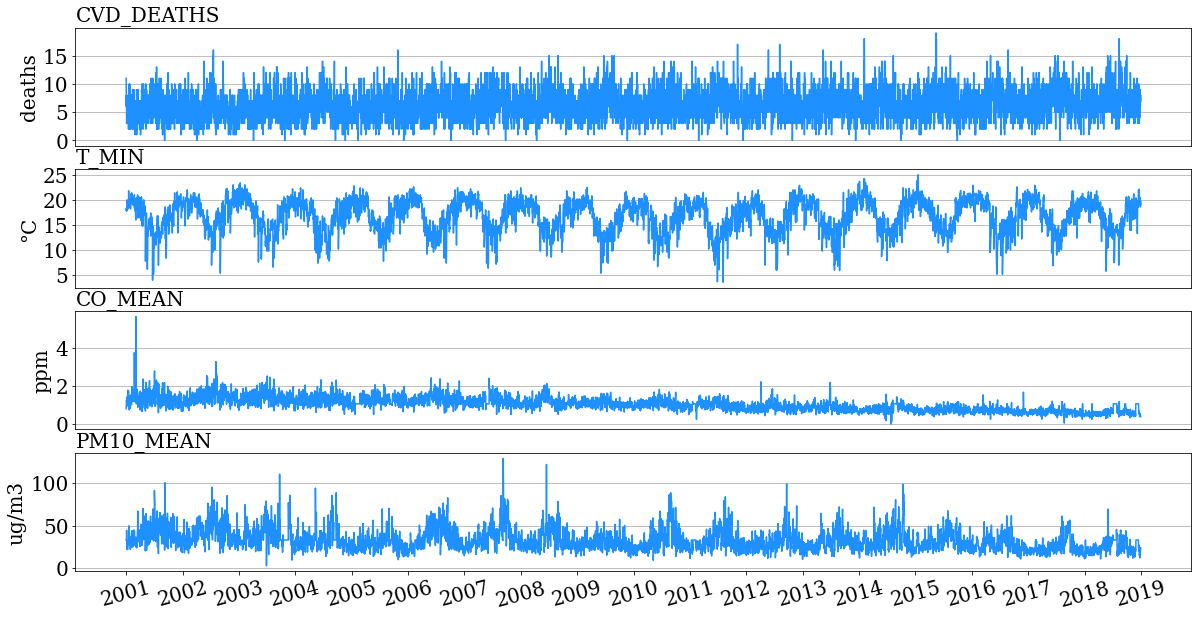

In [ ]:
# measurement unit to plot
unit = ['deaths','°C','ppm','ug/m3']

# specify columns to plot
groups = list(range(0, len(graphs_data.columns),1))

# iteration for each variable
i = 1
fig = plt.figure(figsize=(20,10))
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
for group in groups:
  if i == len(graphs_data.columns):
    flag = True
  else: flag=False
  ax = fig.add_subplot(len(groups), 1, i)
  ax.plot(graphs_data.iloc[:, group],color='dodgerblue')
  ax.xaxis.set_major_locator(mdates.YearLocator(1,1,1))
  ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
  ax.yaxis.grid()
  plt.title(f'{graphs_data.columns[group]}', y=1, x=0,loc='left',fontsize=20)
  plt.xticks(fontsize=20,rotation=15)
  plt.yticks(fontsize=20)
  plt.ylabel(unit[i-1],fontsize=20)
  plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=flag,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=flag)
  i += 1

plt.show()

##**Zoom of CVD deaths and T_MIN variables - 2015 to 2018**

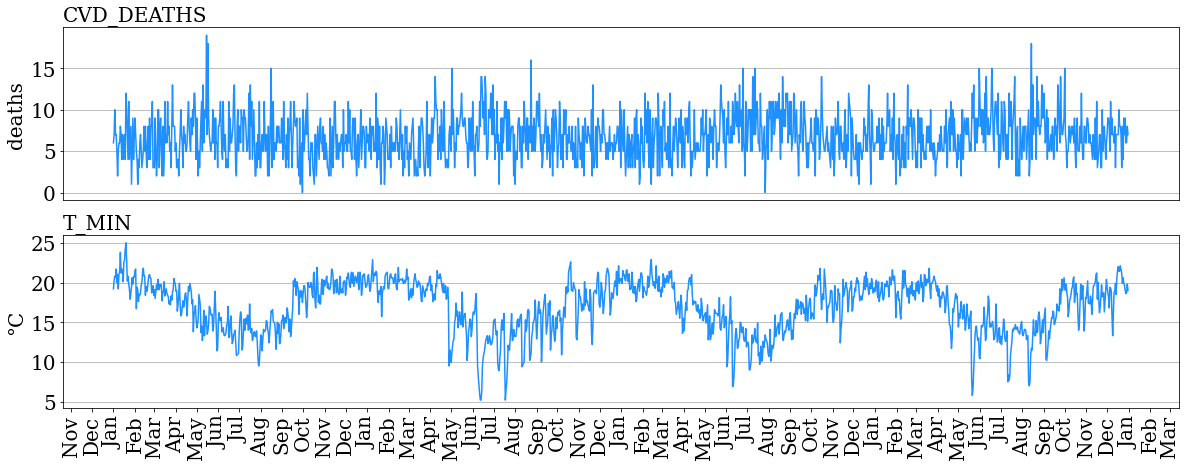

In [ ]:
# time series slice (2015-jan-01 onward)
graphs_data_zoom = graphs_data['2015-01-01' :][['CVD_DEATHS','T_MIN']]

# measurement unit to plot
unit = ['deaths','°C']

# specify columns to plot
groups = list(range(0, len(graphs_data_zoom.columns),1))

# iteration for each variable
i = 1
fig = plt.figure(figsize=(20,7))
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
for group in groups:
  if i == len(graphs_data_zoom.columns):
    flag = True
  else: flag=False
  ax = fig.add_subplot(len(groups), 1, i)
  ax.plot(graphs_data_zoom.iloc[:, group],color='dodgerblue')
  ax.xaxis.set_major_locator(mdates.MonthLocator())
  ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
  ax.yaxis.grid()
  plt.title(f'{graphs_data_zoom.columns[group]}', y=1, x=0,loc='left',fontsize=20)
  plt.xticks(fontsize=20,rotation='vertical')
  plt.yticks(fontsize=20)
  plt.ylabel(unit[i-1],fontsize=20)
  plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=flag,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=flag)
  i += 1

plt.show()

##**Train/Test split 80%-20%**

In [ ]:
#train/test split 70/30
n_train = int(0.8*len(endog))
endog_train = endog.iloc[:n_train].asfreq('D')
endog_test = endog.iloc[n_train:].asfreq('D')
exog_train = exog.iloc[:n_train].asfreq('D')
exog_test = exog.iloc[n_train:].asfreq('D')

##**Adding lags of the predictor variables**

In [ ]:
train_np = exog_train[['CO_MEAN','PM10_MEAN','T_MIN']].values
np.set_printoptions(suppress=True) # supress scientific notation
train_np = train_np.astype('float32') # ensure all data is float

test_np = exog_test[['CO_MEAN','PM10_MEAN','T_MIN']].values
np.set_printoptions(suppress=True) # supress scientific notation
test_np = test_np.astype('float32') # ensure all data is float

# specify the number of lags (days in this case, since each line equals a day)
n_hours = 13


# frame as supervised learning
'''
When transforming the data into supervised (below), we included time t and three more delays (n_hours = 3) for all variables.
ex: var1(t), var1(t-1), var1(t-2), var1(t-3), var2(t), var2(t-1), var2(t-2), var2(t-3), ...
The third argument in the series_to_supervised functions adds onward time steps, being 1 equals time step t, 2 equals time step t+1, etc.
'''
reframed = series_to_supervised(train_np, n_hours, 0) # train data (predictors) with lags
reframed_test = series_to_supervised(test_np, n_hours, 0) # test data (predictors) with lags
reframed_all = series_to_supervised(exog[['CO_MEAN','PM10_MEAN','T_MIN']], n_hours, 0) # all data (train + test)
reframed.head()

,var1(t-13),var2(t-13),var3(t-13),var1(t-12),var2(t-12),var3(t-12),var1(t-11),var2(t-11),var3(t-11),var1(t-10),...,var3(t-4),var1(t-3),var2(t-3),var3(t-3),var1(t-2),var2(t-2),var3(t-2),var1(t-1),var2(t-1),var3(t-1)
13,0.804348,33.256794,18.200001,1.078261,33.256794,17.799999,1.239130,33.256794,18.000000,1.166667,...,19.200001,1.508696,31.086956,19.000000,1.773913,30.916666,18.799999,1.473913,26.958334,18.200001
14,1.078261,33.256794,17.799999,1.239130,33.256794,18.000000,1.166667,44.700001,18.400000,1.334783,...,19.000000,1.773913,30.916666,18.799999,1.473913,26.958334,18.200001,1.139130,30.681818,18.400000
15,1.239130,33.256794,18.000000,1.166667,44.700001,18.400000,1.334783,26.500000,17.799999,1.191304,...,18.799999,1.473913,26.958334,18.200001,1.139130,30.681818,18.400000,1.513333,28.304348,18.600000
16,1.166667,44.700001,18.400000,1.334783,26.500000,17.799999,1.191304,28.125000,19.799999,0.939130,...,18.200001,1.139130,30.681818,18.400000,1.513333,28.304348,18.600000,1.728571,28.000000,19.000000
17,1.334783,26.500000,17.799999,1.191304,28.125000,19.799999,0.939130,22.166666,20.000000,1.413043,...,18.400000,1.513333,28.304348,18.600000,1.728571,28.000000,19.000000,1.320833,39.458332,21.799999


##**Model Fit** - *training set*




/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Residuals mean = 0.00363

Theoretical normal vs Residuals - hypothesis test:
Mann-Whitney U p-value: 0.02381
                                       SARIMAX Results                                        
Dep. Variable:                                      y   No. Observations:                 5246
Model:             SARIMAX(5, 1, 1)x(0, 0, [1, 2], 7)   Log Likelihood              -12331.402
Date:                                Thu, 24 Mar 2022   AIC                          24760.803
Time:                                        15:55:45   BIC                          25082.490
Sample:                                             0   HQIC                         24873.277
                                               - 5246                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------

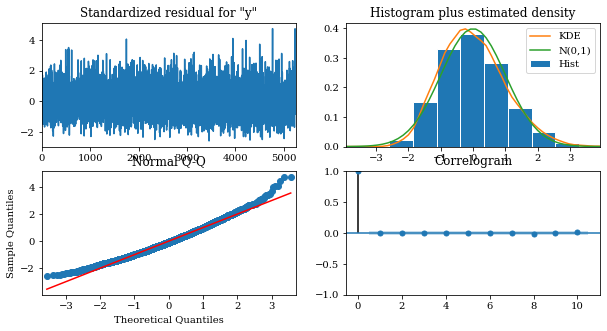

In [ ]:
# Fit the model with statsmodels
mod = SARIMAX(endog_train[n_hours:].values, reframed[:], order=(5,1,1),seasonal_order= (0,0,2,7),trend='c')

fit_res = mod.fit(maxiter=500,method='bfgs',disp=0) #disp controls verbosity
print('\033[1m'+'Residuals mean ='+'\033[0m', round(fit_res.resid.mean(),5))

normal = np.random.normal(0,fit_res.resid.std(),len(fit_res.resid))
mann = mwu(normal,fit_res.resid,alternative = 'two-sided')
print('\033[4m'+'\nTheoretical normal vs Residuals - hypothesis test:'+'\033[0m')
print('\033[1m'+'Mann-Whitney U p-value:'+'\033[0m', round(mann[1],5))
print(fit_res.summary())
fit_res.plot_diagnostics(figsize=(10,5))
plt.show()

##**Statsmodels model** - *all data*

Here, we will pass all the data to the model to make the prediction. The parameters and coefficients will be the same as the model using the training set. The training process doesn't use the test data.

In [ ]:
# All data but with estimated parameters of training set
mod = SARIMAX(endog[n_hours:], exog=reframed_all[:], order=(5,1,1),seasonal_order= (0,0,2,7),trend='c')
res = mod.filter(fit_res.params) #estimated parameters of training set
print(res.summary())

                                       SARIMAX Results                                        
Dep. Variable:                                    all   No. Observations:                 6561
Model:             SARIMAX(5, 1, 1)x(0, 0, [1, 2], 7)   Log Likelihood              -15464.011
Date:                                Thu, 24 Mar 2022   AIC                          31026.021
Time:                                        15:55:53   BIC                          31358.670
Sample:                                    01-14-2001   HQIC                         31141.022
                                         - 12-31-2018                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0002   5.83e-05      3.341      0.001    8.05e-05       0.000
var

##**Prediction graph**

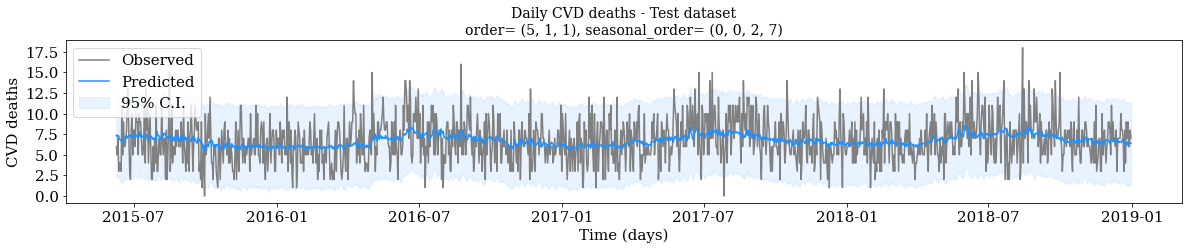

In [ ]:
# predictions
predict = res.get_prediction()
predict_ci = predict.conf_int()

# Graph - Test Set
plt.figure(figsize=(20,3)) # figure size
plt.title(f'''Daily CVD deaths - Test dataset\norder= {mod.order}, seasonal_order= {mod.seasonal_order}''',fontsize=14)
plt.xlabel('Time (days)',fontsize=15)
plt.ylabel('CVD deaths',fontsize=15)

# Plot observed data
plt.plot(endog_test[n_hours:], color='gray',label='Observed')

# Plot predictions
plt.plot(predict.predicted_mean[n_train:]+fit_res.resid.mean(),color='dodgerblue', label='Predicted')
ci = predict_ci[n_train:] #confidence interval
plt.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='dodgerblue', alpha=0.1,label='95% C.I.')

plt.xticks(fontsize=15) # x axis font size
plt.yticks(fontsize=15) # y axis font size
plt.legend(fontsize=15,loc='upper left') # legend font size

plt.show()

##**Root Mean Squared Error** (*RMSE*) - Test set

In [ ]:
mse_one = mean_squared_error(df['all'][n_train+n_hours:],predict.predicted_mean[n_train:])
print('Model RMSE: ',round(np.sqrt(mse_one),3))
mape_one = mape_vectorized(df['all'][n_train+n_hours:],predict.predicted_mean[n_train:])
print('Model MAPE: ',round(mape_one,2),'%')

#NAIVE - MEAN VALUE
naive = pd.Series(np.repeat(df['all'][n_train+n_hours:].mean(),len(df['all'][n_train+n_hours:])))
naive.index = df['all'][n_train+n_hours:].index

mse_one = mean_squared_error(df['all'][n_train+n_hours:],naive)
print('\nNAIVE RMSE: ',round(np.sqrt(mse_one),3))
mape_one = mape_vectorized(df['all'][n_train+n_hours:],naive)
print('NAIVE MAPE: ',round(mape_one,2),'%')

Model RMSE:  2.618
Model MAPE:  43.12 %

NAIVE RMSE:  2.709
NAIVE MAPE:  45.26 %


#**DEATHS PER WEEK**

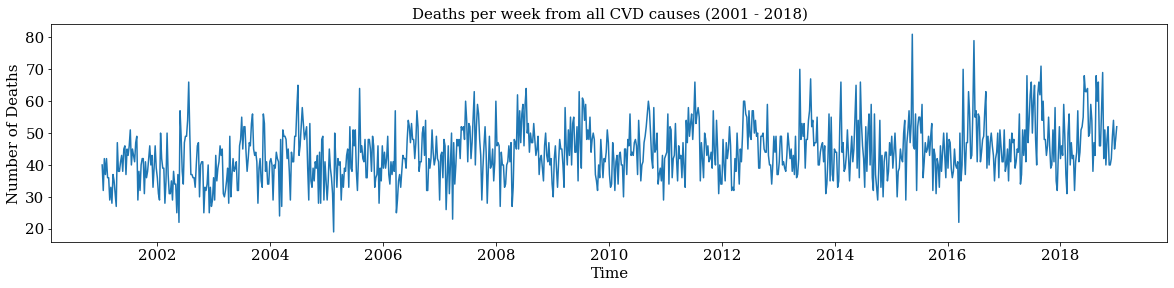

Missing values:
Endog:  0
T_MIN 0


In [ ]:
# Variables
endog = df['all']
exog = df[['T_MIN']]
endog = endog.asfreq('D')
exog = exog.asfreq('D')

# Check missing values
'''print('Missing values\n')
print('Endog            ',np.sum(endog.isnull()))
print(np.sum(exog.isnull()))'''

# week data resample
endog = endog.resample('W-MON',label='right').sum()
exog = exog.resample('W-MON',label='right').sum()
endog = endog[1:]
exog = exog[1:]

plt.figure(figsize=(20,4))
plt.title('Deaths per week from all CVD causes (2001 - 2018)',fontsize=15)
plt.ylabel('Number of Deaths',fontsize=15)
plt.xlabel('Time',fontsize=15)
plt.plot(endog[0:])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

print('Missing values:')
print('Endog: ',np.sum(endog.isnull()))
print(f'{exog.columns.values[0]}',np.sum(exog.isnull()).sum())

##**Train/Test split 80%-20%**

In [ ]:
#train/test split 80/20
n_train = int(0.8*len(exog))
endog_train = endog.iloc[:n_train].asfreq('W-MON')
endog_test = endog.iloc[n_train:].asfreq('W-MON')
exog_train = exog.iloc[:n_train].asfreq('W-MON')
exog_test = exog.iloc[n_train:].asfreq('W-MON')

##**Adding lags of the predictor variables**

In [ ]:
# load dataset
train_np = exog_train[['T_MIN']].values
np.set_printoptions(suppress=True) #supress scientific notation
train_np = train_np.astype('float32') # ensure all data is float

# load dataset
test_np = exog_test[['T_MIN']].values
np.set_printoptions(suppress=True) #supress scientific notation
test_np = test_np.astype('float32') # ensure all data is float

# specify the number of lag (hours in this case, since each line equals a week)
n_hours = 3

# frame as supervised learning
reframed = series_to_supervised(train_np[:,:], n_hours, 0)
reframed_test = series_to_supervised(test_np[:,:], n_hours, 0)
reframed_all = series_to_supervised(exog[['T_MIN']], n_hours, 0)

reframed.head()

,var1(t-3),var1(t-2),var1(t-1)
3,131.399994,132.000000,138.600006
4,132.000000,138.600006,136.600006
5,138.600006,136.600006,141.000000
6,136.600006,141.000000,140.199997
7,141.000000,140.199997,137.199997


##**Model Fit** - *training set*

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  748
Model:               SARIMAX(1, 1, 2)   Log Likelihood               -2530.934
Date:                Thu, 24 Mar 2022   AIC                           5077.868
Time:                        16:43:21   BIC                           5114.797
Sample:                             0   HQIC                          5092.100
                                - 748                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0175      0.005      3.482      0.000       0.008       0.027
var1(t-3)     -0.0182      0.023     -0.779      0.436      -0.064       0.028
var1(t-2)     -0.0558      0.028     -1.988      0.0

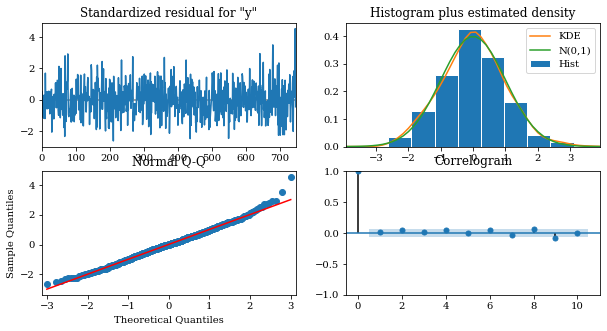

In [ ]:
# Fit the model with statsmodels

mod = SARIMAX(endog_train[n_hours:].values, exog=reframed, order=(1,1,2),seasonal_order= (0,0,0,4),trend='c')
fit_res = mod.fit(maxiter=500,method='bfgs',disp=0) #disp controls verbosity
print(fit_res.summary())
print('\033[1m'+'Residuals mean ='+'\033[0m', round(fit_res.resid.mean(),5))
normal = np.random.normal(0,fit_res.resid.std(),len(fit_res.resid)) #theoretical normal distribution
mann = mwu(normal,fit_res.resid,alternative = 'two-sided') #normality test
print('\033[4m'+'\nTheoretical normal vs Residuals - hypothesis test:'+'\033[0m')
print('\033[1m'+'Mann-Whitney U p-value:'+'\033[0m', round(mann[1],5))

fit_res.plot_diagnostics(figsize=(10,5))
plt.show()

##**Statsmodels model** - *all data*

Here, we will pass all the data to the model to make the prediction. The parameters and coefficients will be the same as the model using the training set. The training process doesn't use the test data.

In [ ]:
# All data but with estimated parameters of training set
mod = SARIMAX(endog[n_hours:], exog=reframed_all, order=(1,1,2),seasonal_order= (0,0,0,4),trend='c')
res = mod.filter(fit_res.params) #estimated parameters of training set
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                    all   No. Observations:                  936
Model:               SARIMAX(1, 1, 2)   Log Likelihood               -3188.571
Date:                Thu, 24 Mar 2022   AIC                           6393.142
Time:                        16:43:52   BIC                           6431.866
Sample:                    01-29-2001   HQIC                          6407.908
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0175      0.004      4.132      0.000       0.009       0.026
var1(t-3)     -0.0182      0.020     -0.916      0.360      -0.057       0.021
var1(t-2)     -0.0558      0.022     -2.502      0.0

##**Prediction graph**

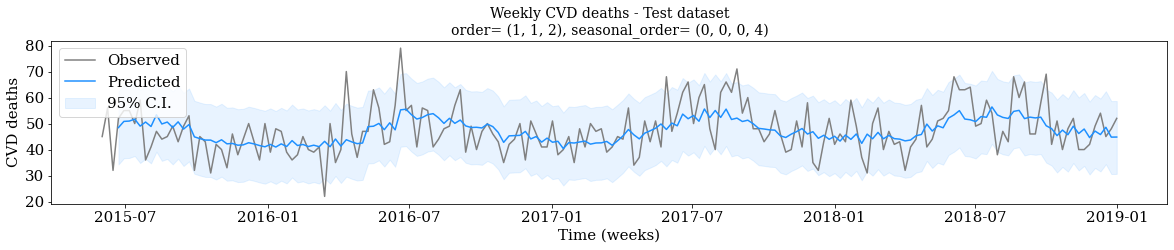

In [ ]:
# predictions
predict = res.get_prediction()
predict_ci = predict.conf_int()

# Graph - Test Set
plt.figure(figsize=(20,3))
plt.title(f'''Weekly CVD deaths - Test dataset\norder= {mod.order}, seasonal_order= {mod.seasonal_order}''',fontsize=14)
plt.xlabel('Time (weeks)',fontsize=15)
plt.ylabel('CVD deaths',fontsize=15)
# Plot data points
plt.plot(endog_test, color='gray',label='Observed')

# Plot predictions
#one-step
plt.plot(predict.predicted_mean[n_train:]+fit_res.resid.mean(),color='dodgerblue', label='Predicted')
ci = predict_ci[n_train:]
plt.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='dodgerblue', alpha=0.1,label='95% C.I.')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15,loc='upper left')
plt.show()

##**Root Mean Squared Error** (*RMSE*) - Test set

In [ ]:
#RMSE - Test
mse_one_test = mean_squared_error(endog[n_train+n_hours:],predict.predicted_mean[n_train:]+fit_res.resid.mean())
print('RMSE One-Step-Ahead: ',round(np.sqrt(mse_one_test),3))
#MAPE - test
mape_one_test = mape_vectorized(endog[n_train+n_hours:],predict.predicted_mean[n_train:]+fit_res.resid.mean())
print('MAPE One-Step-Ahead: ',round(mape_one_test,2),'%')

#NAIVE - MEAN VALUE
naive = pd.Series(np.repeat(endog[n_train+n_hours:].mean(),len(endog[n_train+n_hours:])))
naive.index = endog[n_train+n_hours:].index

mse_one = mean_squared_error(endog[n_train+n_hours:],naive)
print('\nNAIVE RMSE: ',round(np.sqrt(mse_one),3))
mape_one = mape_vectorized(endog[n_train+n_hours:],naive)
print('NAIVE MAPE: ',round(mape_one,2),'%')


RMSE One-Step-Ahead:  7.849
MAPE One-Step-Ahead:  13.4 %

NAIVE RMSE:  9.241
NAIVE MAPE:  15.75 %


#**DEATHS PER MONTH**

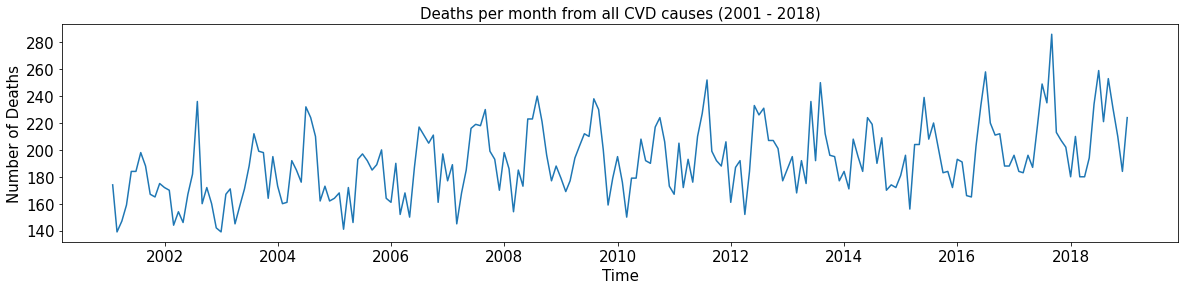

Missing values:
Endog:  0
T_MIN 0


In [ ]:
# Variables
endog = df['all']
exog = df[['T_MIN','CO_MEAN','PM10_MEAN']]
endog = endog.asfreq('D')
exog = exog.asfreq('D')

# Check missing values
'''print('Missing values\n')
print('Endog            ',np.sum(endog.isnull()))
print(np.sum(exog.isnull()))'''

# week data resample
endog = endog.resample('M',label='right').sum()
exog = exog.resample('M',label='right').sum()

plt.figure(figsize=(20,4))
plt.title('Deaths per month from all CVD causes (2001 - 2018)',fontsize=15)
plt.ylabel('Number of Deaths',fontsize=15)
plt.xlabel('Time',fontsize=15)
plt.plot(endog[0:])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

print('Missing values:')
print('Endog: ',np.sum(endog.isnull()))
print(f'{exog.columns.values[0]}',np.sum(exog.isnull()).sum())

##**Train/Test split 80%-20%**

In [ ]:
#train/test split 80/20
n_train = int(0.8*len(exog))
endog_train = endog.iloc[:n_train].asfreq('M')
endog_test = endog.iloc[n_train:].asfreq('M')
exog_train = exog.iloc[:n_train].asfreq('M')
exog_test = exog.iloc[n_train:].asfreq('M')

##**Adding lags of the predictor variables**

In [ ]:
# load dataset
train_np = exog_train[['T_MIN','CO_MEAN','PM10_MEAN']].values
np.set_printoptions(suppress=True) #supress scientific notation
train_np = train_np.astype('float32') # ensure all data is float

# load dataset
test_np = exog_test[['T_MIN','CO_MEAN','PM10_MEAN']].values
np.set_printoptions(suppress=True) #supress scientific notation
test_np = test_np.astype('float32') # ensure all data is float

# specify the number of lag (hours in this case, since each line equals a week)
n_hours = 1

# frame as supervised learning
reframed = series_to_supervised(train_np[:,:], n_hours, 0)
reframed_test = series_to_supervised(test_np[:,:], n_hours, 0)
reframed_all = series_to_supervised(exog[['T_MIN','CO_MEAN','PM10_MEAN']], n_hours, 0)

reframed.head()

,var1(t-1),var2(t-1),var3(t-1)
1,595.400024,39.506760,898.524597
2,556.799988,46.024818,933.262817
3,588.000000,43.078716,1110.448975
4,533.000000,40.246971,1298.320557
5,425.399994,46.083595,1199.943726


##**Model Fit** - *training set*

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  171
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -721.854
Date:                            Tue, 19 Apr 2022   AIC                           1459.709
Time:                                    13:16:01   BIC                           1484.795
Sample:                                         0   HQIC                          1469.888
                                            - 171                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
var1(t-1)     -0.1258      0.034     -3.706      0.000      -0.192      -0.059
var2(t-1)      0.2817      0.251   

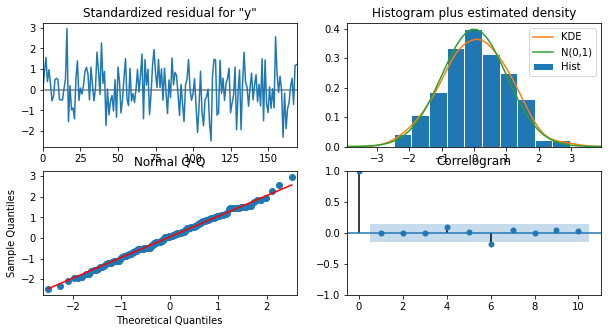

In [ ]:
# Fit the model with statsmodels

mod = SARIMAX(endog_train[n_hours:].values, exog=reframed, order=(1,1,1),seasonal_order= (1,0,1,12),trend=None)
fit_res = mod.fit(maxiter=500,method='bfgs',disp=0) #disp controls verbosity
print(fit_res.summary())
print('\033[1m'+'Residuals mean ='+'\033[0m', round(fit_res.resid.mean(),5))
normal = np.random.normal(0,fit_res.resid.std(),len(fit_res.resid)) #theoretical normal distribution
mann = mwu(normal,fit_res.resid,alternative = 'two-sided') #normality test
print('\033[4m'+'\nTheoretical normal vs Residuals - hypothesis test:'+'\033[0m')
print('\033[1m'+'Mann-Whitney U p-value:'+'\033[0m', round(mann[1],5))

fit_res.plot_diagnostics(figsize=(10,5))
plt.show()

##**Statsmodels model** - *all data*

Here, we will pass all the data to the model to make the prediction. The parameters and coefficients will be the same as the model using the training set. The training process doesn't use the test data.

In [ ]:
# All data but with estimated parameters of training set
mod = SARIMAX(endog[n_hours:], exog=reframed_all, order=(1,1,1),seasonal_order= (1,0,1,12),trend=None)
res = mod.filter(fit_res.params) #estimated parameters of training set
print(res.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                all   No. Observations:                  215
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -911.487
Date:                            Tue, 19 Apr 2022   AIC                           1838.974
Time:                                    13:16:01   BIC                           1865.902
Sample:                                02-28-2001   HQIC                          1849.855
                                     - 12-31-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
var1(t-1)     -0.1258      0.031     -4.078      0.000      -0.186      -0.065
var2(t-1)      0.2817      0.231   

##**Prediction graph**

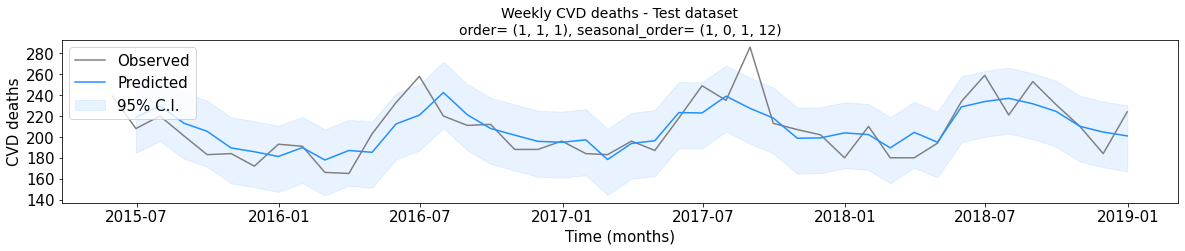

In [ ]:
# predictions
predict = res.get_prediction()
predict_ci = predict.conf_int()

# Graph - Test Set
plt.figure(figsize=(20,3))
plt.title(f'''Weekly CVD deaths - Test dataset\norder= {mod.order}, seasonal_order= {mod.seasonal_order}''',fontsize=14)
plt.xlabel('Time (months)',fontsize=15)
plt.ylabel('CVD deaths',fontsize=15)
# Plot data points
plt.plot(endog_test, color='gray',label='Observed')

# Plot predictions
#one-step
plt.plot(predict.predicted_mean[n_train:]+fit_res.resid.mean(),color='dodgerblue', label='Predicted')
ci = predict_ci[n_train:]
plt.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='dodgerblue', alpha=0.1,label='95% C.I.')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15,loc='upper left')
plt.show()

##**Root Mean Squared Error** (*RMSE*) - Test set

In [ ]:
#RMSE - Test
mse_one_test = mean_squared_error(endog[n_train+n_hours:],predict.predicted_mean[n_train:]+fit_res.resid.mean())
print('RMSE One-Step-Ahead: ',round(np.sqrt(mse_one_test),3))
#MAPE - test
mape_one_test = mape_vectorized(endog[n_train+n_hours:],predict.predicted_mean[n_train:]+fit_res.resid.mean())
print('MAPE One-Step-Ahead: ',round(mape_one_test,2),'%')

#NAIVE - MEAN VALUE
naive = pd.Series(np.repeat(endog[n_train+n_hours:].mean(),len(endog[n_train+n_hours:])))
naive.index = endog[n_train+n_hours:].index

mse_one = mean_squared_error(endog[n_train+n_hours:],naive)
print('\nNAIVE RMSE: ',round(np.sqrt(mse_one),3))
mape_one = mape_vectorized(endog[n_train+n_hours:],naive)
print('NAIVE MAPE: ',round(mape_one,2),'%')


RMSE One-Step-Ahead:  17.429
MAPE One-Step-Ahead:  6.37 %

NAIVE RMSE:  26.801
NAIVE MAPE:  10.25 %
